In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
import math
import sqlite3
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [15]:
movie = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')
movie_info = pd.read_csv('../data/zippedData/rt.movie_info.tsv.gz',sep='\t', compression='gzip')
movie_review = pd.read_csv('../data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
movie_gross = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')
movie_budget = pd.read_csv('../data/zippedData/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('im.db.zip')
#specify the path to the zip file
zip_file_path = '../data/zippedData/im.db.zip'

#Extract the SQLite database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

#connect to extracted SQLite database
database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

In [16]:
# drop "Unnamed: 0" and "original_title" columns from the "movie" dataframe
movie.drop(["Unnamed: 0", "original_title"], axis=1, inplace=True)

# convert "release_date" column to datetime format
movie["release_date"] = pd.to_datetime(movie["release_date"])

# create "year" and "month" columns from "release_date" column
movie["year"] = movie["release_date"].dt.year
movie["month"] = movie["release_date"].dt.month

In [17]:
# convert "production_budget", "domestic_gross" and "worldwide_gross" columns to int64 format
movie_budget["production_budget"] = movie_budget["production_budget"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["domestic_gross"] = movie_budget["domestic_gross"].str.replace(",", "").str.replace("$", "").astype("int64")
movie_budget["worldwide_gross"] = movie_budget["worldwide_gross"].str.replace(",", "").str.replace("$", "").astype("int64")

# create "foreign_gross" column by subtracting "domestic_gross" from "worldwide_gross"
movie_budget["foreign_gross"] = movie_budget["worldwide_gross"] - movie_budget["domestic_gross"]

# create "total_profit" column by subtracting "worldwide_gross" from "production_budget"
movie_budget["total_profit"] = movie_budget["worldwide_gross"] - movie_budget["production_budget"]

# create "total_profit_margin" column by dividing "total_profit" by "production_budget"
movie_budget["total_profit_margin"] = (movie_budget["total_profit"] / movie_budget["production_budget"])*100

In [18]:
movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics
JOIN directors
    USING(movie_id)
JOIN persons
    USING(person_id)
JOIN principals
    USING(person_id)
WHERE category = 'director'
""",conn)

In [19]:
movie_basics.drop_duplicates(subset="primary_title", keep="last", inplace=True)

In [20]:
# drop duplicates from movie_basics based on movie_id column
movie_basics.drop_duplicates(subset="primary_title", keep="last", inplace=True)

In [21]:
# merge movie_basics and movie_budget on movie and primary_title
movie_df = pd.merge(movie_basics, movie_budget, left_on="primary_title", right_on="movie", how="inner")

In [22]:
movie_df.drop(["job", "characters", "movie_id", "primary_profession", "person_id", "primary_title", "original_title"], axis=1, inplace=True)

In [23]:
movie_df = movie_df[["movie", "genre", 'release_month', 'release_year', "production_budget", "domestic_gross", "foreign_gross", "worldwide_gross", "total_profit", "total_profit_margin", "primary_name", 'birth_year', 'death_year']]

KeyError: "['genre', 'release_month', 'release_year'] not in index"

In [ ]:
# create new columns for main genre and sub-genres
movie_df['genre'] = movie_df['genres'].str.split(',').str[0]
movie_df['sub_genres'] = movie_df['genres'].str.split(',').str[1:].apply(lambda x: ','.join(x) if isinstance(x, list) else None)

# drop original genres column
movie_df.drop('genres', axis=1, inplace=True)

KeyError: 'genres'

In [ ]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1775 entries, 0 to 2312
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   start_year           1775 non-null   int64         
 1   runtime_minutes      1709 non-null   float64       
 2   primary_name         1775 non-null   object        
 3   birth_year           1128 non-null   float64       
 4   death_year           12 non-null     float64       
 5   ordering             1775 non-null   int64         
 6   category             1775 non-null   object        
 7   id                   1775 non-null   int64         
 8   release_date         1775 non-null   datetime64[ns]
 9   movie                1775 non-null   object        
 10  production_budget    1775 non-null   int64         
 11  domestic_gross       1775 non-null   int64         
 12  worldwide_gross      1775 non-null   int64         
 13  foreign_gross        1775 non-nul

In [ ]:
movie_df.head()

,start_year,runtime_minutes,primary_name,birth_year,death_year,ordering,category,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,foreign_gross,total_profit,total_profit_margin,release_year,release_month,genre,sub_genres
0,2012,111.0,Robert Lorenz,NaN,NaN,5,director,18,2012-09-21,Trouble with the Curve,60000000,35763137,47818913,12055776,-12181087,-0.203018,2012,9,Drama,Sport
2,2014,104.0,Caryn Waechter,NaN,NaN,5,director,94,2015-04-10,The Sisterhood of Night,1000000,6870,6870,0,-993130,-0.993130,2015,4,Drama,"Mystery,Thriller"
3,2012,145.0,Dean Wright,NaN,NaN,5,director,14,2012-06-01,For Greater Glory: The True Story of Cristiada,12000000,5669081,10026255,4357174,-1973745,-0.164479,2012,6,Drama,"History,War"
4,2012,87.0,Alex Craig Mann,NaN,NaN,5,director,66,2013-06-28,Detention of the Dead,500000,1778,1778,0,-498222,-0.996444,2013,6,Action,"Adventure,Comedy"
5,2013,86.0,Matthew Watts,NaN,NaN,5,director,1,2014-07-01,Mutual Friends,450000,0,0,0,-450000,-1.000000,2014,7,Comedy,Romance


In [ ]:
# convert release_date to datetime and create release_year and release_month columns
movie_df["release_date"] = pd.to_datetime(movie_df["release_date"])
movie_df["release_year"] = movie_df["release_date"].dt.year
movie_df["release_month"] = movie_df["release_date"].dt.month

# filter merged_df to only include movies released in or after 2010
movie_df = movie_df[movie_df["release_year"] >= 2010]

In [ ]:
# Create a boolean mask for movies with total_gross over the high budget threshold
#https://www.studiobinder.com/blog/production-budget/

high_budget = 50000000
low_budget = 5000000

high_budget_mask = movie_df['production_budget'] > high_budget
low_budget_mask = movie_df['production_budget']< low_budget
budget_mask = (movie_df['production_budget'] >= low_budget) & (movie_df['production_budget'] <= high_budget)

# Create a new dataframe for high budget movies
high_budget = movie_df[high_budget_mask]
low_budget = movie_df[low_budget_mask]
mid_budget = movie_df[budget_mask]

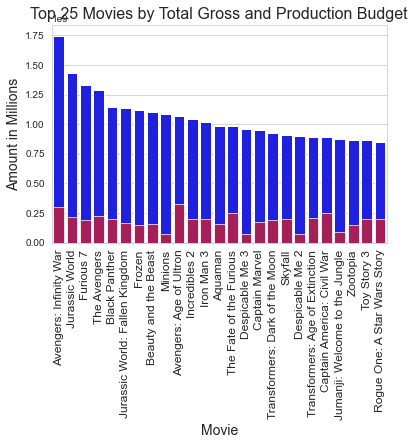

<Figure size 864x864 with 0 Axes>

In [ ]:
# sort dataframe by total gross and select top 50 movies
top_50 = movie_df.sort_values(by='total_profit', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_profit', data=top_50, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_50, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Profit and Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

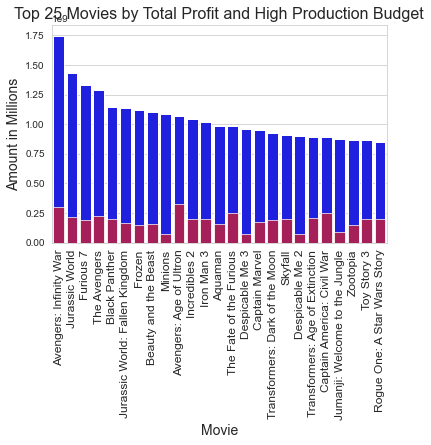

<Figure size 864x864 with 0 Axes>

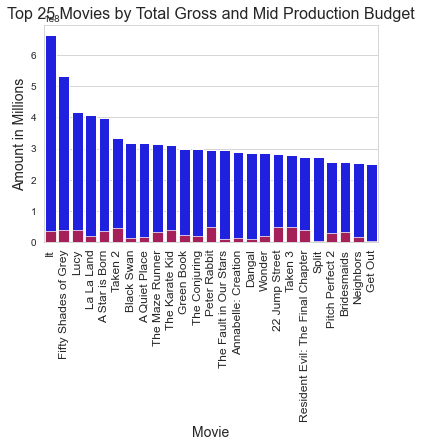

<Figure size 864x864 with 0 Axes>

In [ ]:
# sort dataframe by total gross and select top 50 movies
top_25_high = high_budget.sort_values(by='total_profit', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_profit', data=top_25_high, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_25_high, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Profit and High Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

# sort dataframe by total gross and select top 50 movies
top_25_mid = mid_budget.sort_values(by='total_profit', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_profit', data=top_25_mid, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_25_mid, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Gross and Mid Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

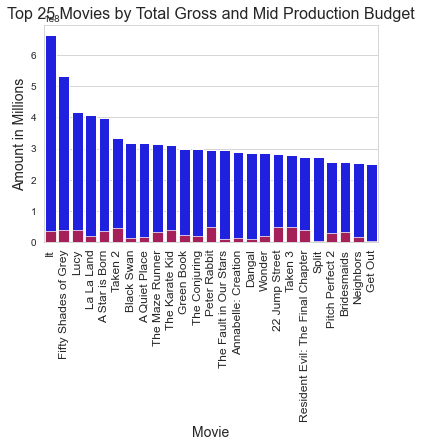

<Figure size 864x864 with 0 Axes>

In [ ]:
# sort dataframe by total gross and select top 50 movies
top_25_mid = mid_budget.sort_values(by='total_profit', ascending=False).head(25)

sns.set_style('whitegrid')

# create stacked bar plot of total gross and production budget
sns.barplot(x='movie', y='total_profit', data=top_25_mid, color='blue')
sns.barplot(x='movie', y='production_budget', data=top_25_mid, color='red', alpha=0.7, estimator=sum)

# add labels and title
plt.xlabel('Movie', fontsize=14)
plt.ylabel('Amount in Millions', fontsize=14)
plt.title('Top 25 Movies by Total Gross and Mid Production Budget', fontsize=16)

# rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=12)

# increase figure size
plt.figure(figsize=(12,12))

# display plot
plt.show()

<AxesSubplot:xlabel='release_year', ylabel='total_profit'>

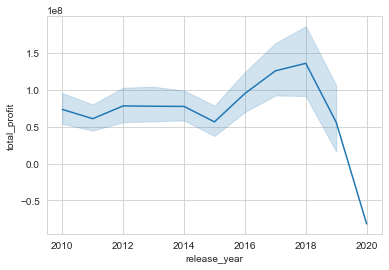

In [ ]:
# create a new dataframe with total gross and year
total_gross_year = movie_df[['total_profit', 'release_year']].copy()
total_gross_year['release_year'] = total_gross_year['release_year']

# plot distribution plot of total gross by year
sns.lineplot(data=total_gross_year, x='release_year', y='total_profit')

<AxesSubplot:xlabel='release_month', ylabel='total_profit'>

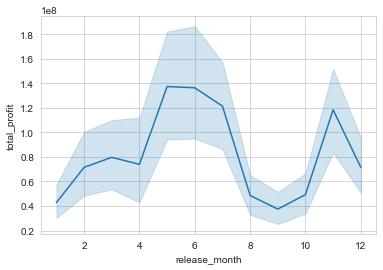

In [ ]:
# create a new dataframe with total gross and year
total_gross_year = movie_df[['total_profit', 'release_month']].copy()
total_gross_year['release_month'] = total_gross_year['release_month']

# plot distribution plot of total gross by year
sns.lineplot(data=total_gross_year, x='release_month', y='total_profit')

NameError: name 'merged_df' is not defined